Notebook purpose

- Determine appropriate model specifications

Background: 

- avg hh savings in uk: https://www.nimblefins.co.uk/savings-accounts/average-household-savings-uk#nogo

In [1]:
import contextlib
import os
import re
import sys

import linearmodels as lm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import s3fs
import seaborn as sns
import tabulate

sys.path.append("/Users/fgu/dev/projects/entropy")
import entropy.data.cleaners as cl
import entropy.data.creators as cr
import entropy.data.selectors as sl
import entropy.figures.figures as figs
import entropy.helpers.aws as ha
import entropy.helpers.data as hd
import entropy.helpers.helpers as hh
from entropy import config

sns.set_style("whitegrid")
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)
pd.set_option("max_colwidth", None)
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

fs = s3fs.S3FileSystem(profile="3di")

## Load raw data

In [2]:
dfs, df = hd.read_samples(["777", "XX7"])
hd.inspect(df)

Time for read_sample    : 4.73 seconds
Time for read_sample    : 8.08 minutes
(16,409,561, 31)


,id,date,user_id,amount,desc,merchant,tag_group,tag,user_female,user_postcode,user_registration_date,user_salary_range,user_yob,account_created,account_id,account_last_refreshed,account_provider,account_type,data_warehouse_date_created,data_warehouse_date_last_updated,debit,latest_balance,merchant_business_line,tag_auto,tag_manual,tag_up,updated_flag,ym,balance,income,entropy_sptac
0,1088864,2012-03-19,57,6.3,1982 18mar 12 debenhams oxford street gb,debenhams,spend,retail,0.0,n8 9,2010-05-13,10k to 20k,1987.0,2016-10-30,273998,2015-08-15 21:37:00,natwest bank,current,2014-07-18,2019-03-04,True,NaN,debenhams store,clothes - everyday or work,NaN,clothes,u,201203,NaN,22136.039062,2.591635
1,1088865,2012-03-19,57,7.8,1982 16mar 12 roadhouse london gb,NaN,NaN,NaN,0.0,n8 9,2010-05-13,10k to 20k,1987.0,2016-10-30,273998,2015-08-15 21:37:00,natwest bank,current,2014-07-18,2017-10-24,True,NaN,NaN,NaN,NaN,NaN,u,201203,NaN,22136.039062,2.591635


## Make analysis data

Make user-ym panel comprising dependent and independent variables

In [17]:
month = pd.Grouper(key="date", freq="m")
idx_cols = ["user_id", month]

column_makers = []


def column_adder(func):
    column_makers.append(func)
    return func


def trim_columns_upper(df, pct=0, ends="upper"):
    return df.apply(lambda x: hd.trim(x, pct=pct))


@column_adder
def obs_count(df):
    return df.groupby(idx_cols).id.count().rename("obs")


@column_adder
def account_balances(df):
    """Calculates average monthly balances for user's savings and current accounts."""
    return (
        df.loc[df.account_type.isin(["current", "savings"])]
        # daily account balances
        .groupby(
            ["user_id", "account_type", "account_id", "date"],
            observed=True,
        )
        .balance.first()
        # daily account type balances
        .groupby(["user_id", "account_type", "date"], observed=True)
        .sum()
        # monthly account type mean balance
        .reset_index()
        .set_index("date")
        .groupby(["user_id", "account_type"])
        .balance.resample("m")
        .mean()
        # reformat
        .unstack(level="account_type")
        .rename(columns={"current": "balance_ca", "savings": "balance_sa"})
    )


@column_adder
def savings_accounts_flows(df):
    """Calculates monthly inflows, outflows, and net-inflows into user's savings accounts."""
    df = df.copy()
    df["debit"] = df.debit.replace({True: "sa_outflows", False: "sa_inflows"})
    is_not_interest_txn = ~df.tag_auto.str.contains("interest", na=False)
    is_savings_account = df.account_type.eq("savings")
    mask = is_not_interest_txn & is_savings_account
    group_cols = idx_cols + ["income", "debit"]

    return (
        df[mask]
        .groupby(group_cols)
        .amount.sum()
        .abs()
        .unstack()
        .fillna(0)
        .reset_index("income")
        .assign(
            sa_net_inflows=lambda df: df.sa_inflows - df.sa_outflows,
            sa_scaled_inflows=lambda df: df.sa_inflows / (df.income / 12) * 100,
            sa_scaled_outflows=lambda df: df.sa_outflows / (df.income / 12) * 100,
            sa_scaled_net_inflows=lambda df: df.sa_scaled_inflows
            - df.sa_scaled_outflows,
        )
        .drop(columns="income")
    )


@column_adder
def tag_entropy(df):
    return df.groupby(idx_cols).entropy_sptac.first()


@column_adder
def total_monthly_spend(df):
    mask = df.tag_group.eq("spend")
    return df[mask].groupby(idx_cols).amount.sum().rename("total_monthly_spend")


@column_adder
def tag_monthly_spend(df):
    df = df.copy()
    df["tag"] = df.tag.cat.rename_categories(lambda x: "tag_spend_" + x)
    mask = df.tag_group.eq("spend")
    group_cols = idx_cols + ["tag"]
    return df[mask].groupby(group_cols, observed=True).amount.sum().unstack().fillna(0)


def main(df):
    return pd.concat((func(df) for func in column_makers), axis=1)


filepath = "/Users/fgu/tmp/en/analysis_data_XX7.parquet"
# data = main(df)
# ha.write_parquet(data, filepath, index=True)

data = ha.read_parquet(filepath)
hd.inspect(data)

/Users/fgu/tmp/en/analysis_data_XX7.parquet (of shape (172845, 20)) written.
(172,845, 20)


obs  balance_ca  balance_sa  sa_inflows  sa_outflows  \
user_id date                                                               
57      2012-03-31   25         0.0         NaN         NaN          NaN   
        2012-04-30   66         0.0         NaN         NaN          NaN   

                    sa_net_inflows  sa_scaled_inflows  sa_scaled_outflows  \
user_id date                                                                
57      2012-03-31             NaN                NaN                 NaN   
        2012-04-30             NaN                NaN                 NaN   

                    sa_scaled_net_inflows  entropy_sptac  total_monthly_spend  \
user_id date                                                                    
57      2012-03-31                    NaN       2.591635           227.250000   
        2012-04-30                    NaN       2.425209           883.679993   

                    tag_spend_retail  tag_spend_services  tag_spend_household  \
user_id date                                                                    
57      2012-03-31         19.870001          163.000000            24.379999   
        2012-04-30          8.280000          217.229996           354.239990   

                    tag_spend_other_spend  tag_spend_hobbies  \
user_id date                                                   
57      2012-03-31                   20.0               0.00   
        2012-04-30                   60.0               9.99   

                    tag_spend_finance  tag_spend_travel  \
user_id date                                              
57      2012-03-31               0.00          0.000000   
        2012-04-30               0.74        202.299988   

                    tag_spend_communication  tag_spend_motor  
user_id date                                                  
57      2012-03-31                      0.0              0.0  
        2012-04-30                     30.9              0.0

### Validation

In [30]:
validator_funcs = []


def validator(func):
    """Adds func to validator functions."""
    validator_funcs.append(func)
    return func


@validator
def obs_not_missing(df):
    """Checks that there are no months for which we have no data.

    This is really another check for whether the `no_missing_months` selector
    function performs its job as intended.
    """
    assert data.obs.isna().sum() == 0


@validator
def user_date_index(df):
    """Checks that index is user-date."""
    assert df.index.names == ["user_id", "date"]


def validate_data(df):
    for func in validator_funcs:
        func(df)
    return df


k = validate_data(data)

## Sumstats

In [39]:
def colname_subset(df, pattern):
    """Returns names of all columns that contain pattern."""
    columns = df.columns
    return columns[columns.str.contains(pattern)]


def sumstats_table(df, cols):
    """Creats basic summary statistics table for colums."""
    order = ["count", "mean", "std", "min", "max", "25%", "50%", "75%"]
    return df[cols].describe().T[order]


def latex_sumstat_table(sumstats_table):
    return tabulate.tabulate(sumstats_table, headers="keys", tablefmt="latex_booktabs")


def write_table(table, path):
    """Writes printed table to path."""
    with open(path, "w+") as f:
        with contextlib.redirect_stdout(f):
            print(table)
    print(f"Table written to {path}.")


pattern = "\w"
cols = colname_subset(data, pattern)
sumstats = sumstats_table(data, cols)
latex_sumstats = latex_sumstat_table(sumstats)
fp = os.path.join(config.TABDIR, "sumstats.tex")
write_table(latex_sumstats, fp)
sumstats

Table written to /Users/fgu/dev/projects/entropy/output/tables/sumstats.tex.


,count,mean,std,min,max,25%,50%,75%
obs,172845.0,94.938014,52.109889,1.000000,803.000000,59.000000,86.000000,120.000000
balance_ca,170936.0,1750.214478,10200.334961,-564218.312500,208640.859375,-300.420227,393.829193,1760.828735
balance_sa,68867.0,3153.196289,10003.270508,-209247.625000,307243.031250,6.673340,450.250000,2499.999512
sa_inflows,63565.0,1025.285522,3292.992432,0.000000,125040.000000,60.000000,251.000000,800.000000
sa_outflows,63565.0,945.789429,2762.888672,0.000000,78773.000000,0.000000,200.000000,803.000000
sa_net_inflows,63565.0,79.496078,3311.727295,-69750.000000,120000.000000,-177.480011,19.860001,260.000000
sa_scaled_inflows,63565.0,53.817720,206.707467,0.000000,11614.739067,3.272988,13.885645,40.961475
sa_scaled_outflows,63565.0,50.387966,173.423395,0.000000,9694.171956,0.000000,10.878588,41.551777
sa_scaled_net_inflows,63565.0,3.429755,199.874119,-9659.549913,11614.739067,-8.958942,0.897252,14.142279
entropy_sptac,172845.0,2.575014,0.237914,0.521190,3.142242,2.434698,2.596723,2.741137


### dev

In [55]:
u = df[df.user_id == 33147]

In [64]:
def min_spend(df, min_txns=10, min_spend=200):
    """At least 5 debits totalling \pounds200 per month

    Drops first and last months for calculations because users will often have
    incomplete data for these months.
    """
    data = df.loc[df.debit, ["user_id", "id", "ym", "amount"]]

    g = data.groupby("user_id")
    first_month = g.ym.transform(min)
    last_month = g.ym.transform(max)
    data = data[data.ym.between(first_month, last_month, inclusive="neither")]

    g = data.groupby(["user_id", "ym"])
    min_monthly_spend = g.amount.sum().groupby("user_id").min()
    min_monthly_txns = g.size().groupby("user_id").min()
    conds = min_monthly_spend.ge(min_spend) & min_monthly_txns.ge(min_txns)
    users = conds[conds].index
    return df.loc[df.user_id.isin(users)]


def min_spend(df):
    data = df.loc[df.debit, ["user_id", "id", "ym", "amount"]]

    g = data.groupby("user_id")
    first_month = g.ym.transform(min)
    last_month = g.ym.transform(max)
    data = data[data.ym.between(first_month, last_month, inclusive="neither")]
    
    g = data.groupby(["user_id", "ym"])
    min_monthly_spend = g.amount.sum().groupby("user_id").min()
    min_monthly_txns = g.size().groupby("user_id").min()
    
    # return min_monthly_txns

    return data


min_spend(u)

,user_id,id,ym,amount
759303,33147,13296249,201312,50.180000
759304,33147,13296242,201312,440.000000
759305,33147,13296255,201312,6.000000
759306,33147,13296256,201312,6.000000
759307,33147,13296254,201312,0.270000
...,...,...,...,...
761433,33147,720328870,202002,48.000000
761434,33147,720328868,202002,50.000000
761435,33147,722148530,202002,82.910004
761436,33147,721751824,202002,300.000000


,id,user_id,amount,desc,merchant,tag_group,tag,user_female,user_postcode,user_registration_date,user_salary_range,user_yob,account_created,account_id,account_last_refreshed,account_provider,account_type,data_warehouse_date_created,data_warehouse_date_last_updated,debit,latest_balance,merchant_business_line,tag_auto,tag_manual,tag_up,updated_flag,ym,balance,income,entropy_sptac
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-03-04,729304121,33147,7.99,1329 03mar 20 audible uk adbl co pymt gb,audible,spend,retail,1.0,cm7 5,2014-01-19,NaN,1943.0,2014-01-19,85310,2020-03-11 18:10:00,natwest bank,current,2020-03-10,1900-01-01,True,3836.699951,audible,books / magazines / newspapers,NaN,books / magazines / newspapers,c,202003,3836.699951,14286.0,3.121928


In [40]:
data[data.obs == 1]

,,obs,balance_ca,balance_sa,sa_inflows,sa_outflows,sa_net_inflows,sa_scaled_inflows,sa_scaled_outflows,sa_scaled_net_inflows,entropy_sptac,total_monthly_spend,tag_spend_retail,tag_spend_services,tag_spend_household,tag_spend_other_spend,tag_spend_hobbies,tag_spend_finance,tag_spend_travel,tag_spend_communication,tag_spend_motor
user_id,date,,,,,,,,,,,,,,,,,,,,
33147,2020-03-31,1,3836.699951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.121928,7.990000,7.990000,0.00,0.000000,0.00,0.0,0.000000,0.00,0.000000,0.000000
36247,2015-04-30,1,675.379761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.121928,55.900002,55.900002,0.00,0.000000,0.00,0.0,0.000000,0.00,0.000000,0.000000
63697,2014-02-28,1,-302.059906,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.121928,11.400000,0.000000,11.40,0.000000,0.00,0.0,0.000000,0.00,0.000000,0.000000
68107,2015-06-30,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.121928,39.020000,0.000000,0.00,0.000000,0.00,0.0,39.020000,0.00,0.000000,0.000000
68877,2014-05-31,1,-90.200157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.121928,7.600000,0.000000,0.00,7.600000,0.00,0.0,0.000000,0.00,0.000000,0.000000
79757,2014-03-31,1,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.121928,71.139999,0.000000,0.00,71.139999,0.00,0.0,0.000000,0.00,0.000000,0.000000
80917,2014-03-31,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.121928,9.980000,0.000000,0.00,9.980000,0.00,0.0,0.000000,0.00,0.000000,0.000000
101457,2017-09-30,1,-6.000008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.121928,6.000000,0.000000,0.00,0.000000,0.00,0.0,6.000000,0.00,0.000000,0.000000
115697,2018-09-30,1,NaN,9.430000,NaN,NaN,NaN,NaN,NaN,NaN,3.121928,-0.020000,0.000000,0.00,0.000000,0.00,0.0,-0.020000,0.00,0.000000,0.000000


## Bivariate plots

In [135]:
data.isna().sum()

obs                           239
balance_ca                    420
balance_sa                 112150
sa_inflows                 117417
sa_outflows                117417
sa_net_inflows             117417
sa_scaled_inflows          117417
sa_scaled_outflows         117417
sa_scaled_net_inflows      117417
entropy_sptac                 239
total_monthly_spend           410
tag_spend_household           410
tag_spend_other_spend         410
tag_spend_services            410
tag_spend_travel              410
tag_spend_hobbies             410
tag_spend_retail              410
tag_spend_finance             410
tag_spend_communication       410
tag_spend_motor               410
dtype: int64

In [133]:
def trim_column_values(df, **kwargs):
    return df.apply(hd.trim, **kwargs)


def make_data(df, col_names, trim_pct=5, trim_how="both"):
    col_names = ["entropy_sptac"] + list(col_names)
    return (
        df.loc[:, col_names].pipe(trim_column_values, pct=trim_pct, how=trim_how)
        # .melt(ignore_index=False)
        # .reset_index("entropy_sptac")
    )


pattern = "sa_inflows"
col_names = colname_subset(data, pattern)

make_data(data, col_names)

entropy_sptac  sa_inflows
user_id date                                 
57      2012-11-30       2.397678         NaN
        2012-12-31       2.498083         NaN
        2013-01-31       2.230370         NaN
        2013-02-28       2.489379         NaN
        2013-03-31       2.361511         NaN
...                           ...         ...
589617  2020-03-31            NaN         NaN
        2020-04-30       2.777777         NaN
        2020-05-31            NaN         NaN
        2020-06-30            NaN         NaN
        2020-07-31       2.864084         NaN

[174655 rows x 2 columns]

In [84]:
def trim_column_values(df, **kwargs):
    return df.apply(hd.trim, **kwargs)


def make_data(df, col_names=None, **trim_kws):
    if col_names is None:
        col_names = df.columns
    return (
        df.set_index("entropy_sptac", append=True)
        .loc[:, col_names]
        # .pipe(trim_column_values, **trim_kws)
        .melt(ignore_index=False)
        .reset_index("entropy_sptac")
    )


def make_lmplot(df):
    sns.lmplot(
        data=df,
        y="value",
        x="entropy_sptac",
        lowess=True,
        x_bins=10,
        ci=99,
        col="variable",
        col_wrap=3,
    )


pattern = "sa_inflows"
columns = colname_subset(data, pattern)
d = make_data(data, col_names=columns)
# s = d.sample(frac=0.25)
# make_regplot(s)
d.dropna(subset=["value"])

entropy_sptac    variable       value
user_id date                                             
57      2018-05-31       2.539643  sa_inflows  300.000000
        2018-06-30       2.497777  sa_inflows  500.000000
        2018-07-31       2.325304  sa_inflows  500.000000
        2018-08-31       2.543220  sa_inflows  500.000000
        2018-09-30       2.187621  sa_inflows  500.000000
...                           ...         ...         ...
589317  2019-10-31       2.507676  sa_inflows  922.000000
        2019-12-31       2.515537  sa_inflows  332.000000
        2020-01-31       2.493242  sa_inflows    0.000000
        2020-04-30       2.434146  sa_inflows    0.000000
        2020-07-31       2.781264  sa_inflows   33.720001

[57238 rows x 3 columns]

In [120]:
k = data.balance_sa
t = hd.trim(k, pct=1, how="lower")
dd = pd.DataFrame({"orig": k, "truncated": t})
dd.describe()

,orig,truncated
count,62505.000000,61879.000000
mean,3895.286377,4019.692383
std,12023.717773,11659.721680
min,-209247.625000,-1233.949707
25%,138.234634,150.049988
50%,836.731689,866.973328
75%,3304.209961,3350.729980
max,351928.562500,351928.562500


## Testing

In [79]:
def make_regplot(df):
    sns.regplot(
        data=df,
        y="value",
        x="entropy_sptac",
        x_bins=20,
    )

count    23824.000000
mean       287.636108
std        145.446182
min        100.000000
25%        184.320007
50%        250.000000
75%        400.000000
max        600.000000
Name: value, dtype: float64

In [80]:
data

obs   balance_ca  balance_sa  sa_inflows  sa_outflows  \
user_id date                                                                 
57      2012-11-30  20.0  8447.646484         NaN         NaN          NaN   
        2012-12-31  32.0  8575.141602         NaN         NaN          NaN   
        2013-01-31  38.0  8174.982422         NaN         NaN          NaN   
        2013-02-28  37.0  7484.873535         NaN         NaN          NaN   
        2013-03-31  40.0  6646.179199         NaN         NaN          NaN   
...                  ...          ...         ...         ...          ...   
589617  2020-03-31  55.0 -1038.730591         NaN         NaN          NaN   
        2020-04-30  17.0  -813.920593         NaN         NaN          NaN   
        2020-05-31  20.0   163.734436         NaN         NaN          NaN   
        2020-06-30  23.0   397.719482         NaN         NaN          NaN   
        2020-07-31  31.0  1852.866699         NaN         NaN          NaN   

                    sa_net_inflows  sa_scaled_inflows  sa_scaled_outflows  \
user_id date                                                                
57      2012-11-30             NaN                NaN                 NaN   
        2012-12-31             NaN                NaN                 NaN   
        2013-01-31             NaN                NaN                 NaN   
        2013-02-28             NaN                NaN                 NaN   
        2013-03-31             NaN                NaN                 NaN   
...                            ...                ...                 ...   
589617  2020-03-31             NaN                NaN                 NaN   
        2020-04-30             NaN                NaN                 NaN   
        2020-05-31             NaN                NaN                 NaN   
        2020-06-30             NaN                NaN                 NaN   
        2020-07-31             NaN                NaN                 NaN   

                    sa_scaled_net_inflows  entropy_sptac  total_monthly_spend  \
user_id date                                                                    
57      2012-11-30                    NaN       2.397678          1411.040039   
        2012-12-31                    NaN       2.498083          1740.310059   
        2013-01-31                    NaN       2.230370          1454.369995   
        2013-02-28                    NaN       2.489379          1764.510010   
        2013-03-31                    NaN       2.361511          1481.949951   
...                                   ...            ...                  ...   
589617  2020-03-31                    NaN       2.100003           317.589996   
        2020-04-30                    NaN       2.777777           190.910004   
        2020-05-31                    NaN       2.927799           214.240005   
        2020-06-30                    NaN       2.954004           219.259995   
        2020-07-31                    NaN       2.864084           339.480011   

                    tag_spend_household  tag_spend_other_spend  \
user_id date                                                     
57      2012-11-30          1230.430054              90.000000   
        2012-12-31          1398.550049             121.400002   
        2013-01-31          1268.680054              44.799999   
        2013-02-28          1287.640015              70.000000   
        2013-03-31          1172.589966             100.000000   
...                                 ...                    ...   
589617  2020-03-31            26.799999               0.000000   
        2020-04-30             0.000000               0.000000   
        2020-05-31            22.299999               0.000000   
        2020-06-30             2.850000               0.000000   
        2020-07-31           440.250000               0.000000   

                    tag_spend_services  tag_spend_travel  tag_spend_hobbies  \
user_id date

### Gross flows

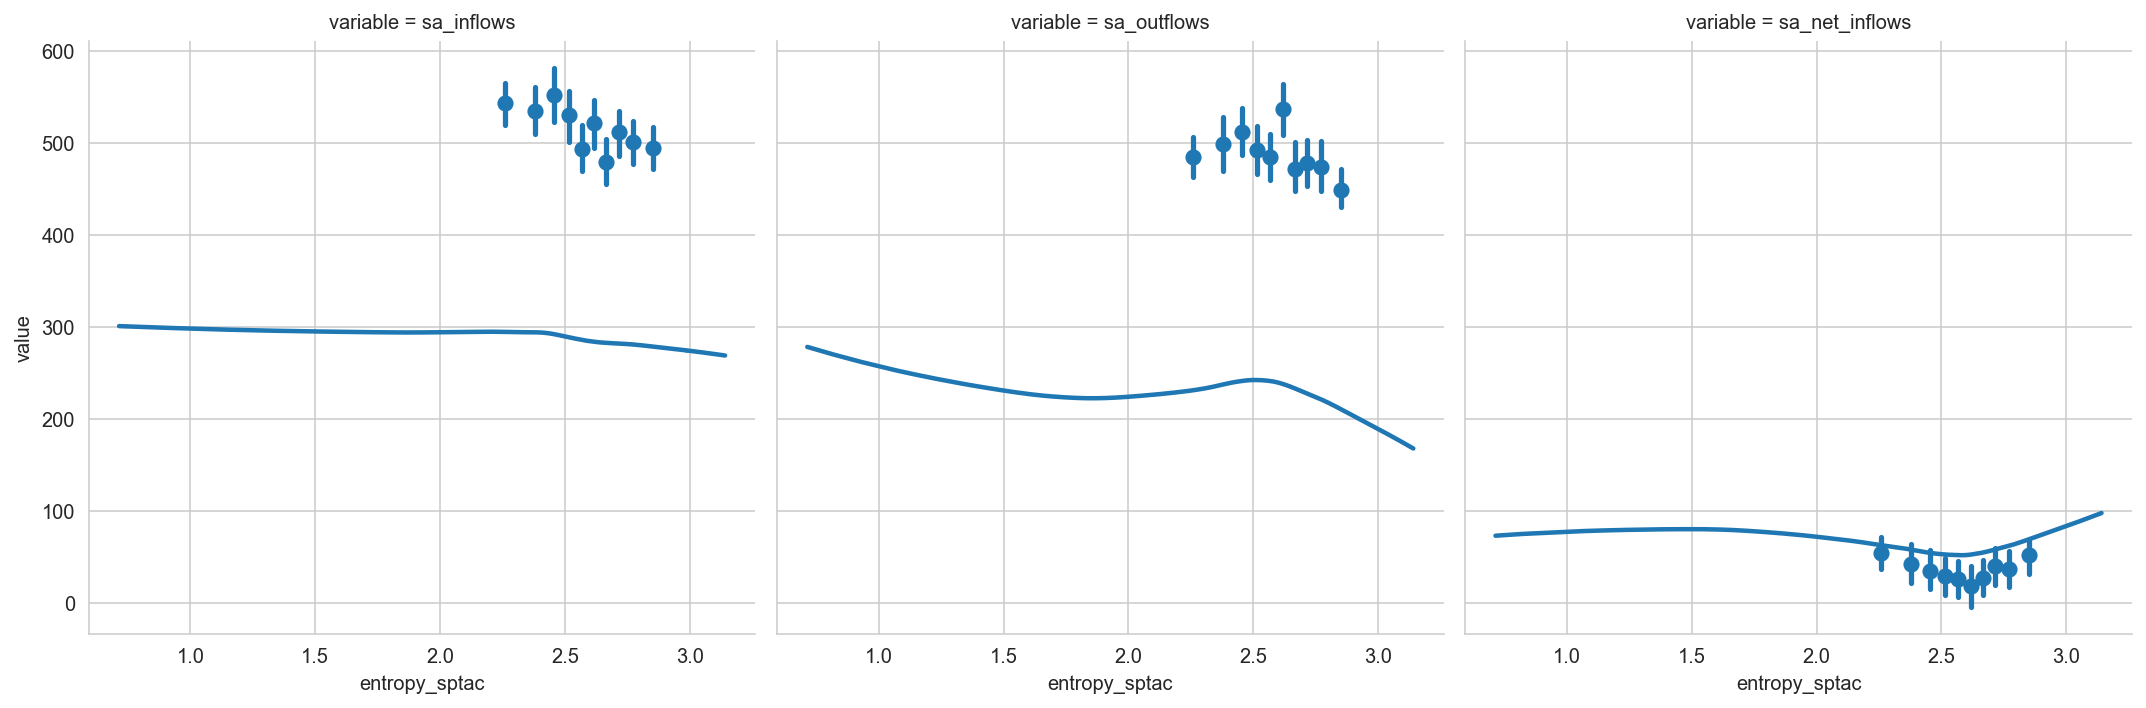

In [309]:
pattern = "sa_[oin]"
columns = colname_subset(data, pattern)
d = make_data(data, col_names=columns)
make_plot(d)

### Scaled flows

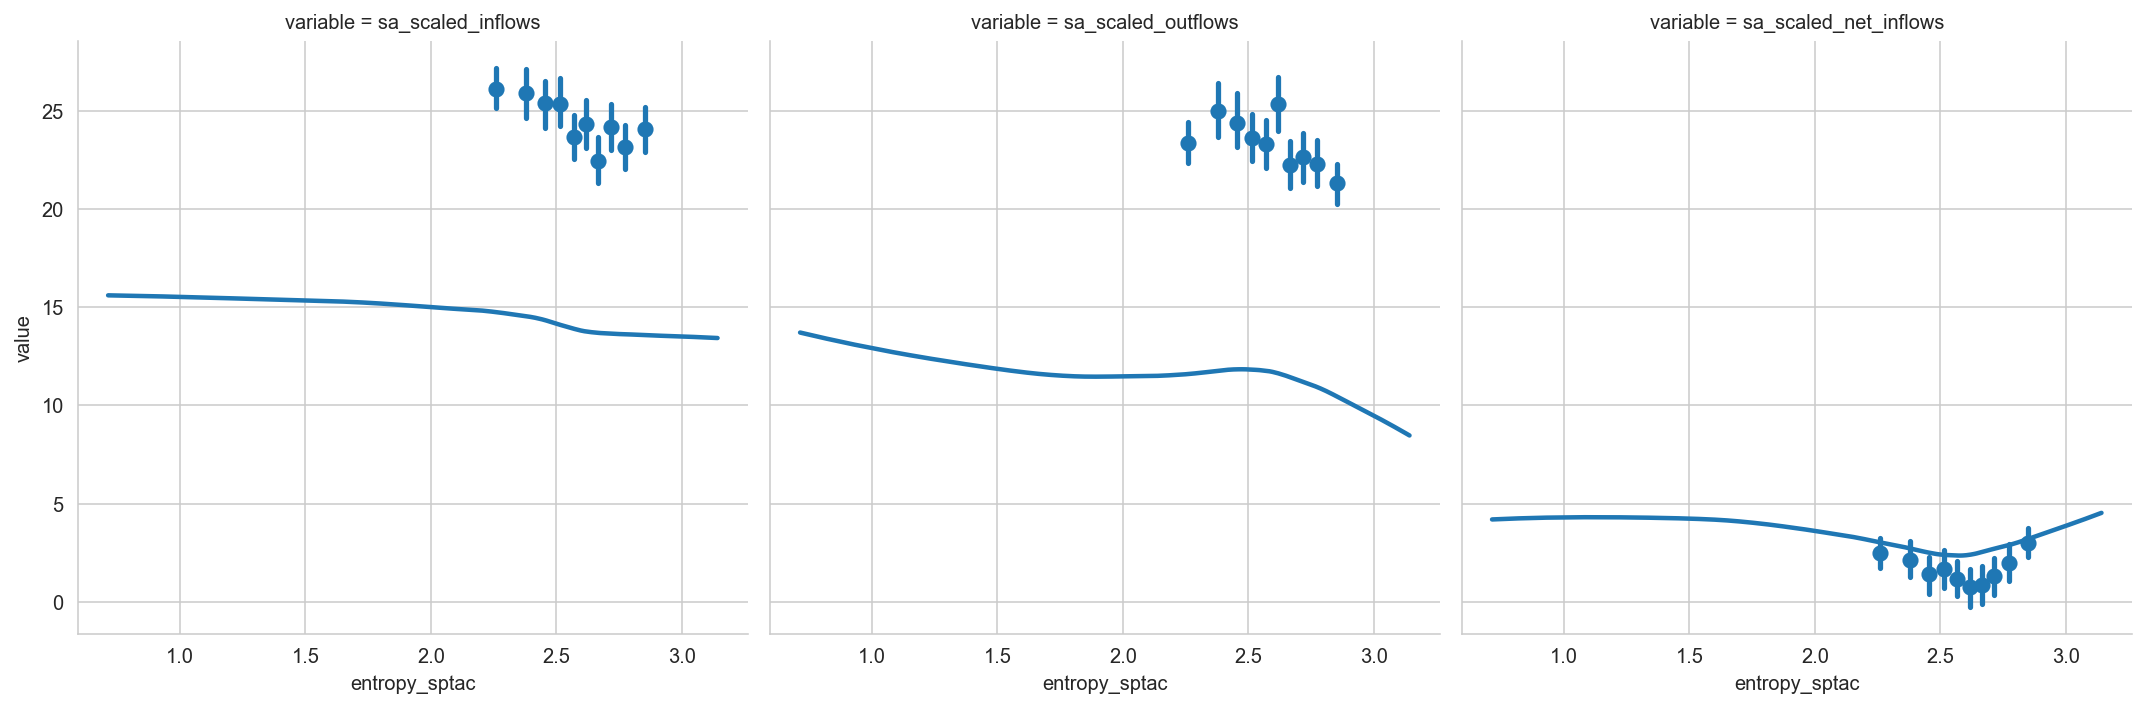

In [310]:
pattern = "sa_scaled_[oin]"
columns = colname_subset(data, pattern)
d = make_data(data, col_names=columns)
make_plot(d)

### Balances

In [ ]:
pattern = "balance_"
columns = colname_subset(data, pattern)
d = make_data(data, col_names=columns)
make_plot(d)

KeyboardInterrupt: 

Exception ignored in: 'statsmodels.nonparametric._smoothers_lowess.calculate_weights'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 2, in sum
KeyboardInterrupt: 


## Main results

Full FE equation as baseline

## Lagged-dependent variable